In [1]:
import sys
import os
from itertools import cycle
from time import time

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader

from sklearn.linear_model import LassoLars
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import OrthogonalMatchingPursuit

sys.path.append(os.pardir)
sys.path.append(os.path.join(os.pardir, os.pardir))
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

from src.dataset.dataloaders import get_dataset
from src.dataset.torch_dataset import PatchAndFlatenDataset, NormalizationType
#from src.dictionary.basic_dictionary_learning import base_algo1, batched_algo1, test_algo2_similarities
from src.dictionary.dictionary_algo import DictionaryAlgoBasic, DictionaryAlgoParallel


In [15]:
patch_size=(12, 12)
patches_per_image=5
batch_size=32

test_dir = os.path.join(notebook_dir, "../dataset/data/berkeley/test/")

test_dataset = PatchAndFlatenDataset(
    directory=test_dir, patch_size=patch_size, patches_per_image=patches_per_image, norm_type=NormalizationType.ZSCORE
)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [16]:
train_loader, _, _ = get_dataset("berkeley",  patch_size=patch_size, patches_per_image=5, batch_size=batch_size, norm_type=NormalizationType.ZSCORE)

for p in train_loader:
    print(p.shape)  # [bs, c*h*w]
    break
for p in test_loader:
    print(p[0].shape)  # [bs, c, h, w]
    print(p[1].shape)  # [bs, c*h*w]
    break

torch.Size([32, 432])
torch.Size([32, 3, 12, 12])
torch.Size([32, 432])


# Base pipeline

## View data

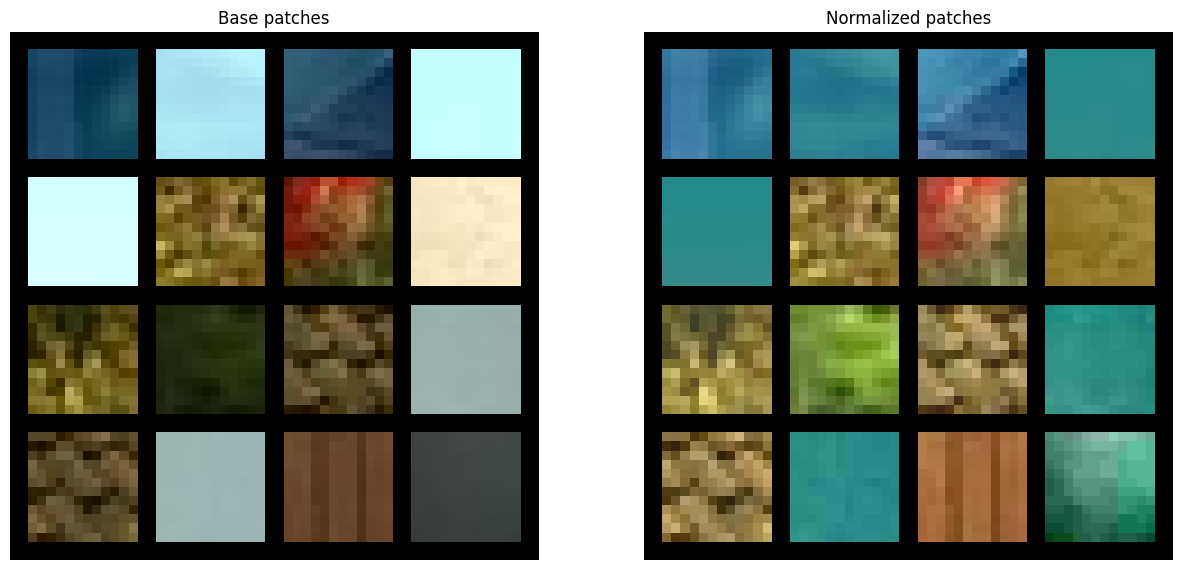

In [17]:
def plot_patches_and_flattens(patches, flattens, patch_size, nrow=4):
    c = 3
    p_h, p_w = patch_size

    flattens_reshaped = flattens.view(-1, c, p_h, p_w)

    grid_flatten = make_grid(flattens_reshaped[:nrow * nrow], nrow=nrow, normalize=True)
    grid_np_fl = grid_flatten.permute(1, 2, 0).cpu().numpy()


    grid = make_grid(patches[:nrow*nrow], nrow=nrow, normalize=True, value_range=(0, 1))
    grid_np_base = grid.permute(1, 2, 0).cpu().numpy()

    fig, ax = plt.subplots(1, 2, figsize=(15, 7))

    ax[0].imshow(grid_np_base)
    ax[0].set_title("Base patches")
    ax[0].axis('off')

    ax[1].imshow(grid_np_fl)
    ax[1].set_title("Normalized patches")
    ax[1].axis('off')

    plt.show()

for p, f in test_loader:
    plot_patches_and_flattens(p, f, patch_size=patch_size, nrow=4)
    break


## Train

In [221]:
from tqdm import tqdm
class FiniteGenerator:
    def __init__(self, iterable, nb_elt):
        self.iterable = iterable
        self.nb_elt = nb_elt
    def __len__(self):
        return self.nb_elt
    def __iter__(self):
        infinite_loader = cycle(self.iterable)
        
        for k in tqdm(range(self.nb_elt)):
            yield next(infinite_loader)

In [18]:
m = patch_size[0]*patch_size[1]*3

In [ ]:
infinite_x_loader = cycle(train_loader)
generator = FiniteGenerator(infinite_x_loader, int(1e4))
DictLearner = DictionaryAlgoParallel(m=m, k=200, lbd=1.2/(m*np.sqrt(m)), dic_update_steps=100, use_cuda=False, dico_update="quick_update_cv_check", n_jobs=-1)
DictLearner.fit(generator)


100%|██████████| 1000/1000 [01:07<00:00, 14.71it/s]


In [ ]:
torch.save(DictLearner.D, "D_1e4_12_12_3_200.pt")

## Util

In [ ]:
def patch_reconstruction(D, flatten_x, mean, std, l1_penalty, n_nonzero_coefs=10, omp=False):
        if omp:
            omp_solver = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs, fit_intercept=False)
            omp_solver.fit(X=D, y=flatten_x)
            alpha = torch.tensor(omp_solver.coef_, dtype=torch.float32)
        else:
            lasso = LassoLars(alpha=l1_penalty, fit_intercept=False)
            lasso.fit(X=D, y=flatten_x)
            alpha = torch.tensor(lasso.coef_, dtype=torch.float32)

        x_reconstructed_scaled = torch.matmul(D.clone().detach(), alpha).clone().detach().numpy()
        x_reconstructed = (x_reconstructed_scaled * std + mean)
        
        reconstructed_x = torch.tensor(x_reconstructed).reshape(3, 12, 12).permute(1, 2, 0) # [H, W, C]

        return np.clip(np.array(reconstructed_x).astype(np.int32), 0, 255)


In [11]:
def visualize_patch_reconstruction(D, patch_x, flatten_x, l1_penalty, n_nonzero_coefs=10, omp=False, mean=None, std=None):
        if not mean:
            mean = flatten_x.mean()
        if not std:
            std = flatten_x.std()

        std = std.item() if isinstance(std, torch.Tensor) else std
        mean = mean.item() if isinstance(mean, torch.Tensor) else mean

        if std > 0:
            normalized_x = (flatten_x - mean) / std
        else:
            normalized_x = flatten_x.clone()

        if omp:
            omp_solver = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs, fit_intercept=False)
            omp_solver.fit(X=D, y=normalized_x)
            alpha = torch.tensor(omp_solver.coef_, dtype=torch.float32)
        else:
            lasso = LassoLars(alpha=l1_penalty, fit_intercept=False)
            lasso.fit(X=D, y=normalized_x)
            alpha = torch.tensor(lasso.coef_, dtype=torch.float32)

        x_reconstructed_scaled = torch.matmul(torch.tensor(D), alpha).numpy()
        x_reconstructed = (x_reconstructed_scaled * std + mean)  # De-normalize

        original_x = patch_x.permute(1, 2, 0)  # [H, W, C] from [C, H, W]
        scaled_x = normalized_x.reshape(3, 12, 12).permute(1, 2, 0)  # [H, W, C]
        # reconstructed_x = x_reconstructed.reshape(3, 16, 16).permute(1, 2, 0)  # [H, W, C]
        reconstructed_x = torch.tensor(x_reconstructed).reshape(3, 12, 12).permute(1, 2, 0)  # [H, W, C]

        # Scaling
        original_rgb = (original_x - torch.min(original_x)) / (torch.max(original_x) - torch.min(original_x))
        scaled_rgb = (scaled_x - torch.min(scaled_x)) / (torch.max(scaled_x) - torch.min(scaled_x))
        reconstructed_rgb = (reconstructed_x - torch.min(reconstructed_x)) / (torch.max(reconstructed_x) - torch.min(reconstructed_x))
        # reconstructed_rgb = reconstructed_x

        plt.figure(figsize=(16, 8))

        plt.subplot(2, 3, 1)
        plt.imshow(original_rgb)
        plt.title("Original X (RGB)")
        plt.axis("off")

        plt.subplot(2, 3, 2)
        plt.imshow(scaled_rgb)
        plt.title("Scaled X (RGB)")
        plt.axis("off")

        plt.subplot(2, 3, 3)
        plt.imshow(reconstructed_rgb)
        plt.title("Reconstructed X (RGB)")
        plt.axis("off")

        plt.subplot(2, 1, 2)
        plt.bar(np.arange(len(alpha)), alpha.numpy())
        plt.title("Alpha Activations")
        plt.xlabel("Dictionary Index")
        plt.ylabel("Activation Magnitude")
        plt.tight_layout()

        plt.show()

In [20]:
def visualize_reconstruction(D, loader, l1_penalty, n_nonzero_coefs=10, omp=False):
    for _ in range(3):
        patch_x, flatten_x = next(loader)
        patch_x, flatten_x = patch_x[0], flatten_x[0]

        visualize_patch_reconstruction(D, patch_x, flatten_x, l1_penalty, n_nonzero_coefs=n_nonzero_coefs, omp=omp)


In [142]:
def reconstrucion_metrics(D, loader, l1_penalty, omps=[1,2,5,10,20,50], N=1000):
    omps_metrics = {omp_val:[] for omp_val in omps}
    lars = []
    for _ in range(N):
        patch_x, flatten_x = next(loader)
        patch_x, flatten_x = patch_x[0], flatten_x[0]
        patch_x = patch_x.permute(1, 2, 0)
        patch_x = np.clip(np.array(255*patch_x).astype(np.int32), 0, 255)
        mean = patch_x.mean()
        std = patch_x.std()
        for omp in omps_metrics.keys():
            reconstructed_patch = patch_reconstruction(D=D, flatten_x=flatten_x, mean=float(mean), std=float(std), l1_penalty=l1_penalty, omp=True, n_nonzero_coefs=omp)
            reconstructed_patch = np.clip(np.array(reconstructed_patch).astype(np.int32), 0, 255)

            omps_metrics[omp].append((patch_x - reconstructed_patch).astype(np.float64)**2)
        reconstructed_patch = patch_reconstruction(D=D, flatten_x=flatten_x, mean=mean, std=std, l1_penalty=l1_penalty, omp=False)
        lars.append((patch_x - reconstructed_patch).astype(np.float64)**2)
        
    
    print("Mean reconstruction error:")
    for omp, errors in omps_metrics.items():
        print(f"OMP with {omp} components: {np.mean(errors)}")
    print(f"LARS: {np.mean(lars)}")

In [145]:
l1_penalty = 1.2/(m*np.sqrt(m))

test_D = torch.load("D_1e3_12_12_3_200.pt", weights_only=True)

reconstrucion_metrics(test_D, cycle(test_loader), l1_penalty)

Mean reconstruction error:
OMP with 1 components: 990.9641805555556
OMP with 2 components: 776.7249953703704
OMP with 5 components: 503.6424074074074
OMP with 10 components: 317.6226898148148
OMP with 20 components: 174.08291898148147
OMP with 50 components: 51.365092592592596
LARS: 12.481770833333334


## Reconstruction

### Test Dataset

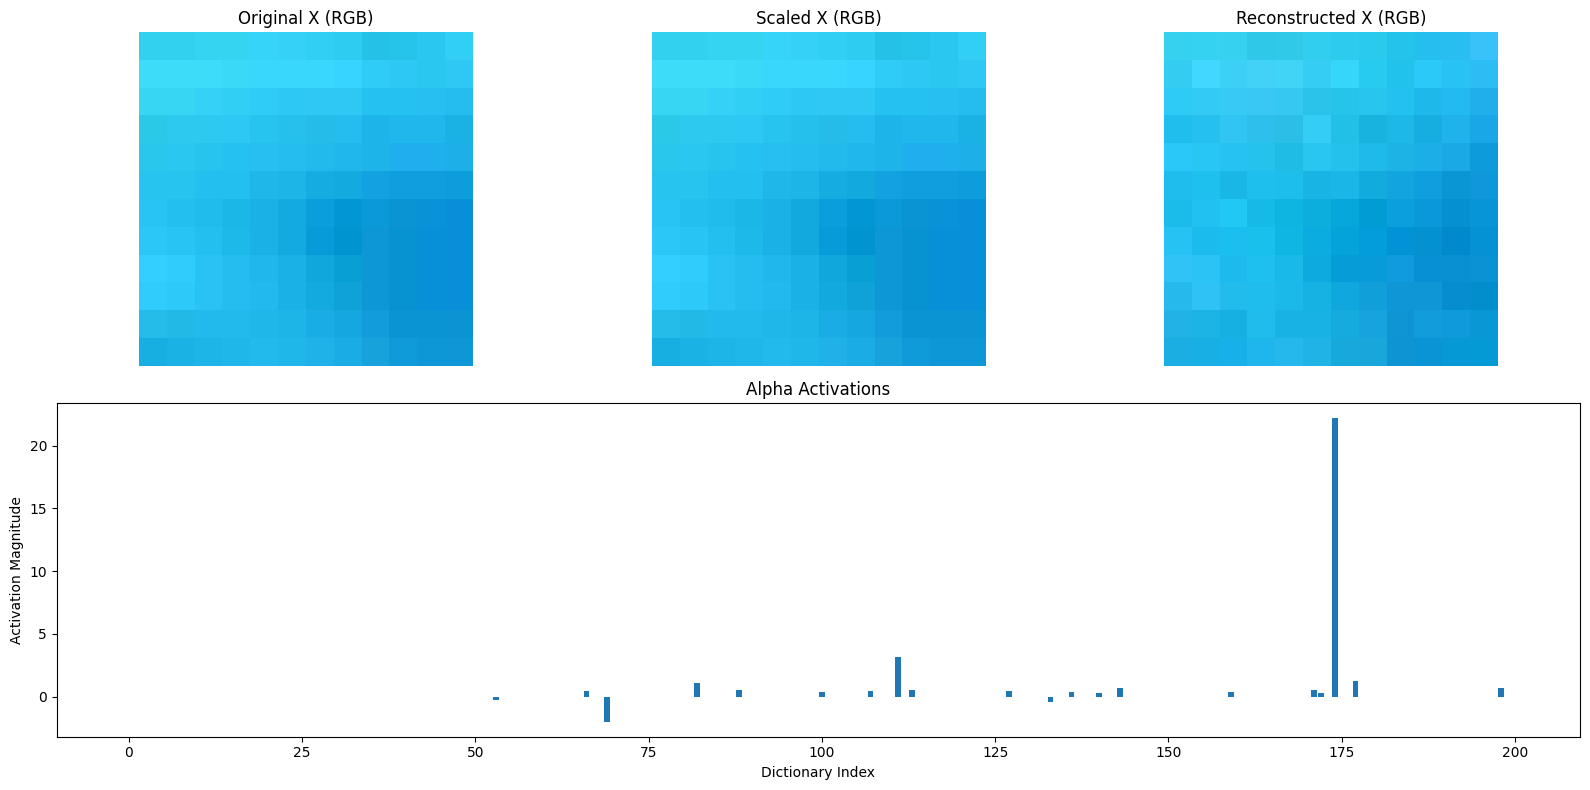

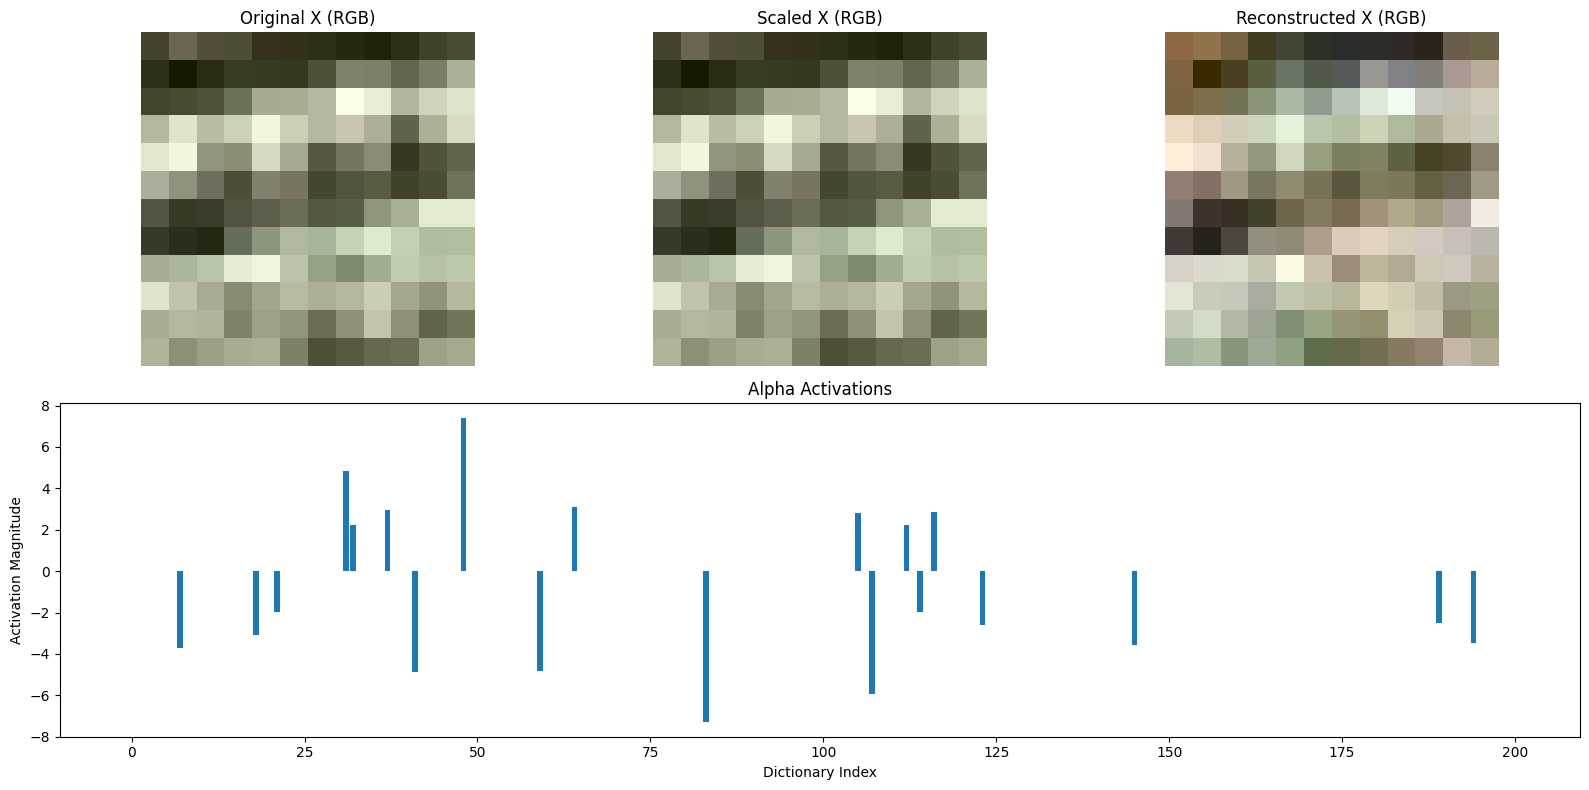

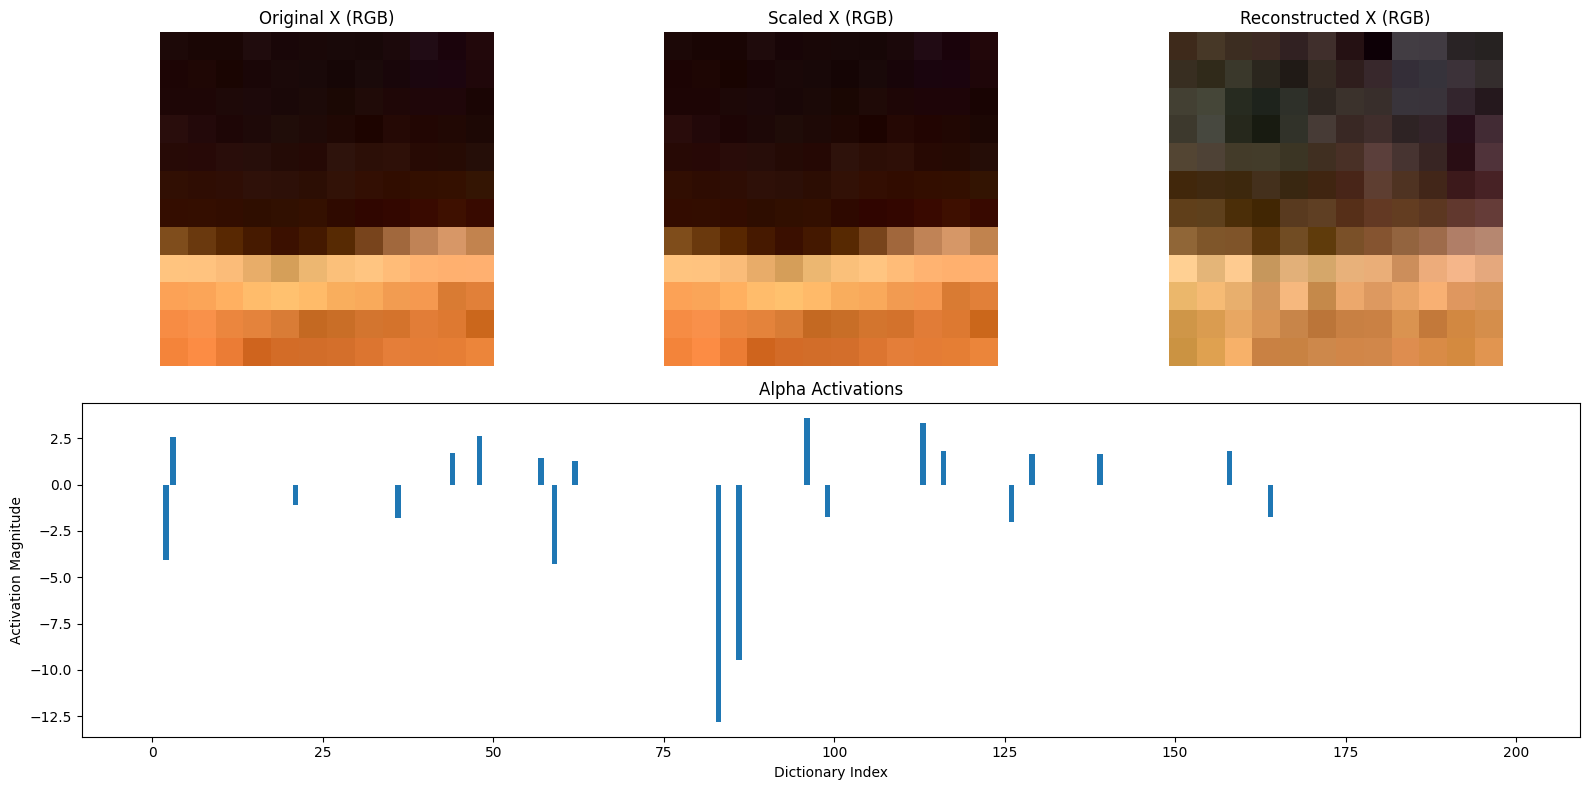

In [84]:
visualize_reconstruction(test_D, cycle(test_loader), l1_penalty, omp=True, n_nonzero_coefs=20)

# Denoising

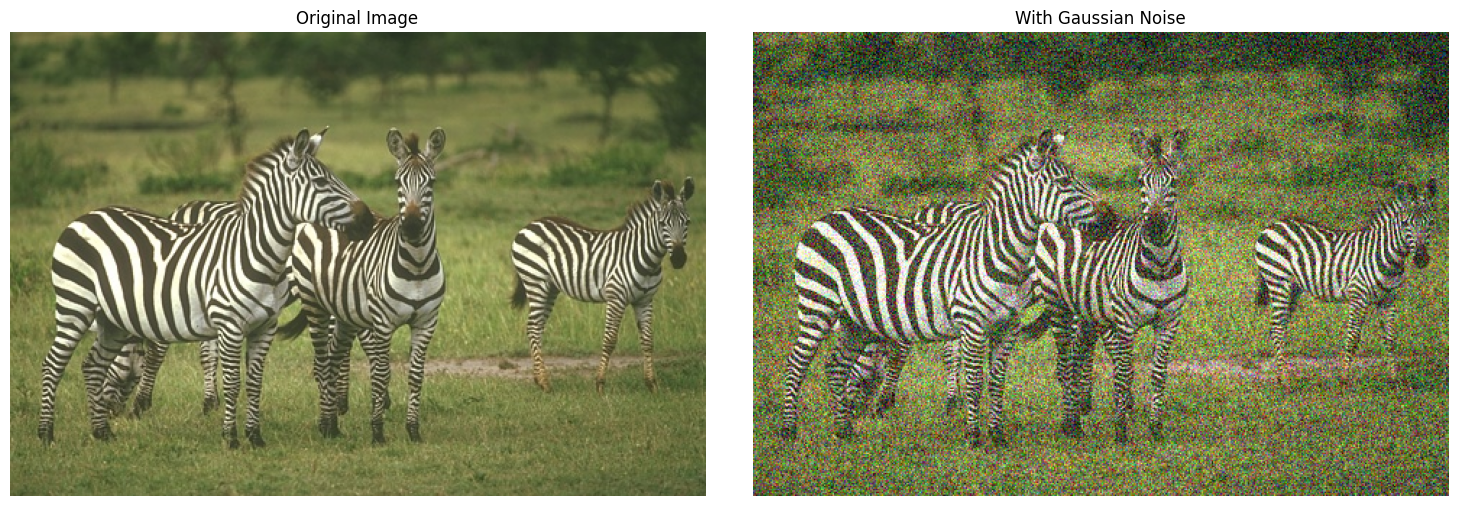

In [38]:
from PIL import Image
from src.utils.img import add_gaussian_noise, add_text_noise

img = Image.open(os.path.join(notebook_dir, "../dataset/data/berkeley/val/253027.jpg")).convert("RGB")

img_gaussian = np.array(add_gaussian_noise(img, mean=0, std=40))
img_text = np.array(add_text_noise(img, font_size=20, color=(255, 0, 0, 50)))
img = np.array(img)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(img_gaussian)
axes[1].set_title("With Gaussian Noise")
axes[1].axis("off")

# axes[2].imshow(img_text)
# axes[2].set_title("With Text Noise")
# axes[2].axis("off")

plt.tight_layout()
plt.show()


In [39]:
D = torch.load("D_1e5_12_12_3_200.pt", weights_only=True)

torch.Size([36, 432])


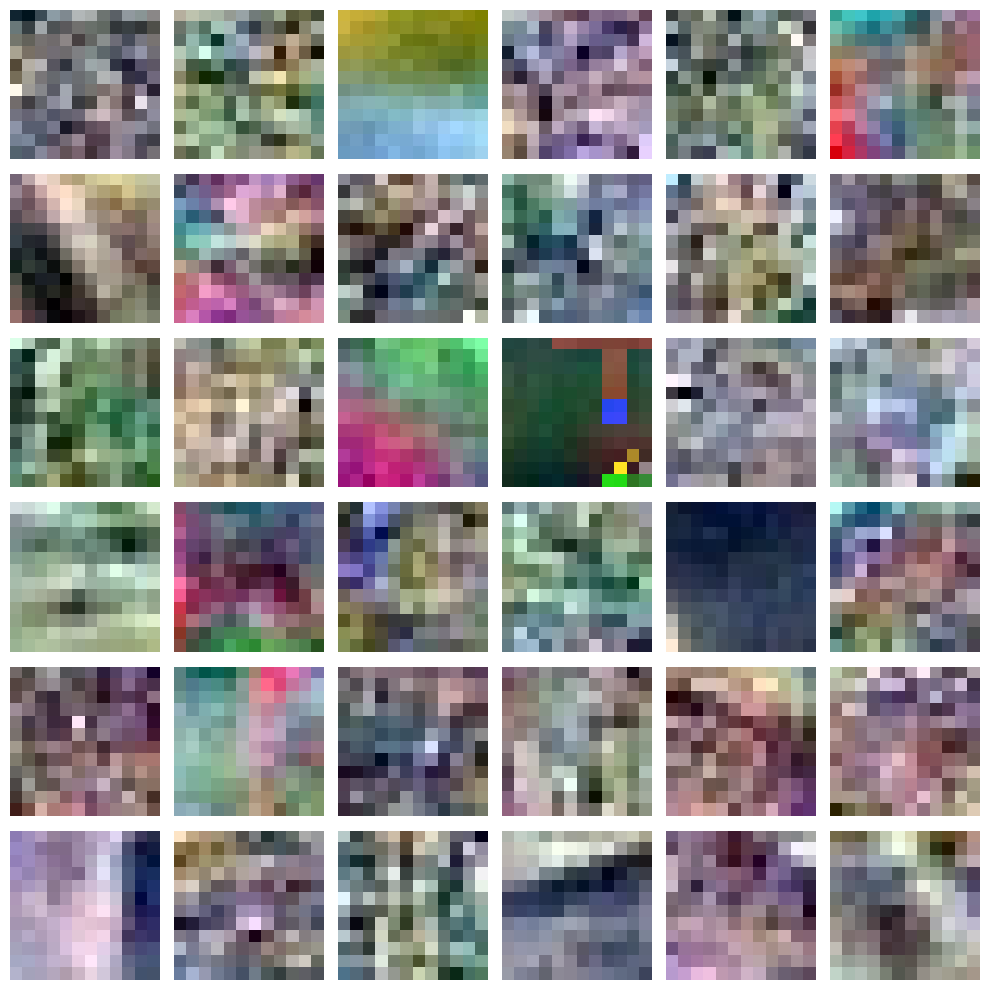

In [40]:
patch_width = 12
num_patches_to_plot = 36
begin_index = 0
grid_size = int(np.ceil(np.sqrt(num_patches_to_plot)))

selected_patches = D[:, begin_index:begin_index + num_patches_to_plot].T
print(selected_patches.shape)

def normalize_patch(patch):
    patch_min = patch.min()
    patch_max = patch.max()
    return (patch - patch_min) / (patch_max - patch_min)

fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(selected_patches):
        patch = 20*selected_patches[i].reshape(3, patch_width, patch_width).permute(1, 2, 0).detach().cpu().numpy()
        ax.imshow(normalize_patch(patch))
    ax.axis('off')

plt.tight_layout()
plt.show()

Original image patches: (4108, 12, 12, 3)
Gaussian noise patches: (4108, 12, 12, 3)
Text noise patches: (4108, 12, 12, 3)


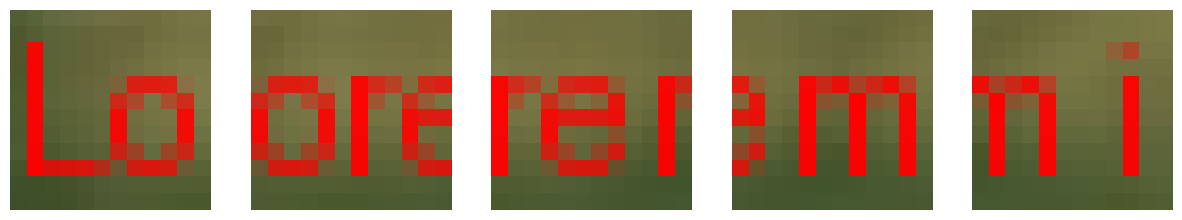

In [41]:
def extract_patches(img_array, patch_size=12, stride=1):
    H, W, _ = img_array.shape
    patches = []
    
    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            patch = img_array[i:i + patch_size, j:j + patch_size, :]
            patches.append(patch)
    
    return np.array(patches)

patch_size = 12
stride = 6

# Extract patches
patches_original = extract_patches(img, patch_size=patch_size, stride=stride)
patches_gaussian = extract_patches(img_gaussian, patch_size=patch_size, stride=stride)
patches_text = extract_patches(img_text, patch_size=patch_size, stride=stride)

print(f"Original image patches: {patches_original.shape}")
print(f"Gaussian noise patches: {patches_gaussian.shape}")
print(f"Text noise patches: {patches_text.shape}")

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(patches_text[i])
    ax.axis("off")
plt.show()

torch.Size([3, 12, 12])


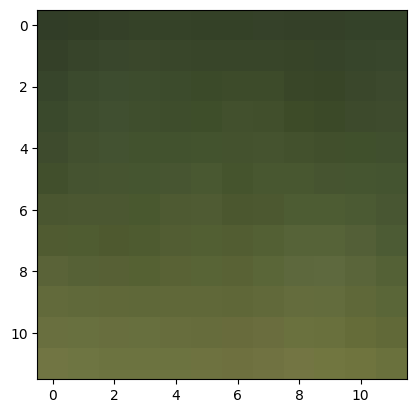

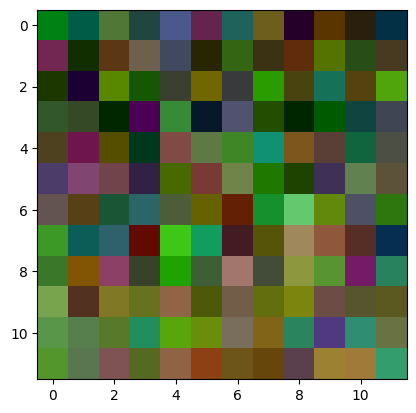

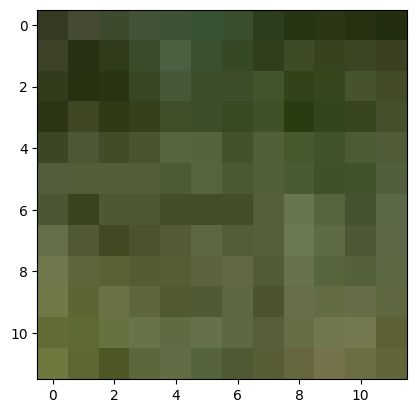

In [42]:
patch_original = torch.tensor(patches_original[300], dtype=torch.float32).permute(2, 0, 1)
patch = torch.tensor(patches_gaussian[300], dtype=torch.float32).permute(2, 0, 1)
print(patch.shape)
patch_flat = patch.flatten()

mean = patch_flat.mean()
std = patch_flat.std()
if std > 0:
    patch_flat = (patch_flat - mean) / std

reconstructed = patch_reconstruction(D, patch_flat, mean=float(mean), std=float(std), l1_penalty=l1_penalty, n_nonzero_coefs=10, omp=True)
# visualize_patch_reconstruction(D, patch_original, patch_flat, l1_penalty, n_nonzero_coefs=10, omp=True, mean=mean, std=std)
plt.imshow(patches_original[300])
plt.show()
plt.imshow(patches_gaussian[300])
plt.show()
plt.imshow(np.clip(np.array(reconstructed).astype(np.int32), 0, 255))
plt.show()

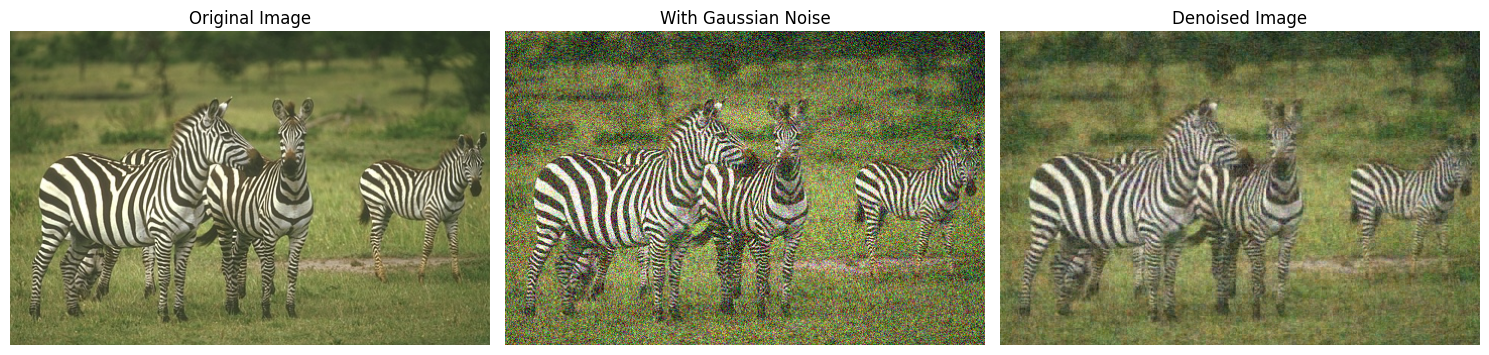

MSE with Gaussian Noise: 25382.18885721491
MSE with Denoised Image: 344.9765192250534


In [147]:
import numpy as np

def reconstruct_from_patches(patches, image_shape, patch_size, stride):
    H, W, C = image_shape
    reconstructed_image = np.zeros((H, W, C), dtype=np.int32)
    weight_map = np.zeros((H, W, C), dtype=np.int32)
    
    patch_idx = 0
    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            reconstructed_image[i:i+patch_size, j:j+patch_size, :] = reconstructed_image[i:i+patch_size, j:j+patch_size, :] + patches[patch_idx]
            weight_map[i:i+patch_size, j:j+patch_size, :] = weight_map[i:i+patch_size, j:j+patch_size, :]+ 1
            patch_idx += 1

    weight_map[weight_map == 0] = 1

    reconstructed_image = reconstructed_image.astype(np.float64)
    weight_map = weight_map.astype(np.float64)
    reconstructed_image /= weight_map
    
    return np.clip(reconstructed_image.astype(np.int32), 0, 255)

reconstructed_patches = []
for noised_patch in patches_gaussian:
    patch = torch.tensor(noised_patch, dtype=torch.float32).permute(2, 0, 1)
    patch_flat = patch.flatten()
    mean = patch_flat.mean()
    std = patch_flat.std()
    if std > 0:
        patch_flat = (patch_flat - mean) / std
    reconstructed = patch_reconstruction(D, patch_flat, mean=float(mean), std=float(std), l1_penalty=l1_penalty, n_nonzero_coefs=10, omp=True)
    reconstructed_patches.append(np.clip(np.array(reconstructed).astype(np.int32), 0, 255))

denoised_image = reconstruct_from_patches(reconstructed_patches, img_gaussian.shape, patch_size, stride)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img[:-10,:-5])
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(img_gaussian[:-10,:-5])
axes[1].set_title("With Gaussian Noise")
axes[1].axis("off")

axes[2].imshow(denoised_image[:-10,:-5])
axes[2].set_title("Denoised Image")
axes[2].axis("off")

plt.tight_layout()
plt.show()

mse_noisy = np.mean((img[:-10, :-5] - img_gaussian[:-10, :-5]).astype(np.float64) ** 2)
mse_denoised = np.mean((img[:-10, :-5] - denoised_image[:-10, :-5]).astype(np.float64) ** 2)

print("MSE with Gaussian Noise:", mse_noisy)
print("MSE with Denoised Image:", mse_denoised)
